## 使用SageMaker+XGBoost，将时间序列转换为监督学习，完成预测性维护的实践
https://github.com/liangyimingcom/Use-SageMaker_XGBoost-convert-Time-Series-into-Supervised-Learning-for-predictive-maintenance
**关键字**：SageMaker；XGBoost；Python；滑窗；滑动窗口方法；时间序列预测转化为监督学习问题；将多元时间序列数据转换为监督学习问题；如何用Python将时间序列问题转化为有监督学习问题；时间序列预测的机器学习模型；Machine Learning；ML；

# Step4: [补充内容] 准备用于训练的数据集，完成数据预处理与特征工程：

### 本章节内容Contents  
   - [ ] 1）探索相关性；
   - [ ] 2）缩小特征值范围；
   - [ ] 3）确认数据集从282列缩减为58个列
   

In [1]:
#使用 pandas 库加载和显示此原始数据集。 生成的 `df` 变量是 pandas [DataFrame]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

import os
from datetime import datetime
from time import gmtime, strftime, sleep

### 使用dataframe load原始数据集，并进行初步的处理


In [2]:
## load csv path
csv_path = './yiming-arraged/10000871-part_ac-part1.csv'
df = pd.read_csv(csv_path,low_memory=False)
#df.describe()

#数据清理： 按照时间排序数组后，然后删除时间的属性
df = df.drop(['MAC', 'SYSTEM_IMEI', 'name', 'TYPEID', 'createTime', 'topic', 'shutTime', 'TIME (2)'], axis=1)
df['time']=pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)
df = df.drop(['time'], axis=1)

#数据清理: 转化 code 到 hascode = true/false 
# 根据hascode属性的请看，添加Ishascode =true/false 的列
df['hascode'] = (np.where(df['code'].isnull().values, False, True)).astype(object)
df = df.drop(['code'], axis=1)
df = df.fillna(0)
#for testig
df = df.head(10000)

df.describe()

,1S0Z7F92N86S68KI_10_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_10_COMPCURRENT,1S0Z7F92N86S68KI_10_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_10_COMPLOAD,1S0Z7F92N86S68KI_10_COMPPOWER,1S0Z7F92N86S68KI_10_COMPRUNTIME,1S0Z7F92N86S68KI_10_COMPSPEED,1S0Z7F92N86S68KI_10_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_10_COMPVOLTAGE,1S0Z7F92N86S68KI_10_CONDSIDEEXHAUSTPRESS,...,SYSTEM_SELECTINOUT,SYSTEM_SELECTREFRHEAT,SYSTEM_SYSFAILURE,SYSTEM_UNITFAILURE,SYSTEM_UNITPOWER,SYSTEM_UNITRATEDFULLLOAD,SYSTEM_UNITRUNFEEDBACK,SYSTEM_UNITSTOPFEEDBACK,SYSTEM_VERSION40000,SYSTEM_VERSION40001
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.0,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000900,0.0,0.0,0.0,6.433800,0.0,0.000900,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029988,0.0,0.0,0.0,21.384269,0.0,0.029988,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,156.000000,0.0,1.000000,0.0,0.0,0.0


我们来深入了解一下。按照现代标准，这是一个相对较大的数据集，有 130W 条记录。
每条记录使用 超过282个属性来描述设备信息。
这些属性如下：
- `name`： 设备名称
- `time`： 设备timestamp（时间打点）
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- ....
- `code?`：设备故障代码（分类，代表不同的报警类型）

最后一个属性 `code?` 称为*目标属性*，即我们希望 ML 模型预测的属性。

#### 开始探索数据以及属性之间的关系并使其实现可视化，用直方图来查看各个属性的值的分布情况，并计算出值属性的汇总统计数据，如均值、最小值、最大值、标准差等。 
对于类别变量，我们需要查看频率表。更为直观的方法是为每个数值特征构建直方图；

In [3]:
# 显示汇总统计数据
display(df.describe())

,1S0Z7F92N86S68KI_10_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_10_COMPCURRENT,1S0Z7F92N86S68KI_10_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_10_COMPLOAD,1S0Z7F92N86S68KI_10_COMPPOWER,1S0Z7F92N86S68KI_10_COMPRUNTIME,1S0Z7F92N86S68KI_10_COMPSPEED,1S0Z7F92N86S68KI_10_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_10_COMPVOLTAGE,1S0Z7F92N86S68KI_10_CONDSIDEEXHAUSTPRESS,...,SYSTEM_SELECTINOUT,SYSTEM_SELECTREFRHEAT,SYSTEM_SYSFAILURE,SYSTEM_UNITFAILURE,SYSTEM_UNITPOWER,SYSTEM_UNITRATEDFULLLOAD,SYSTEM_UNITRUNFEEDBACK,SYSTEM_UNITSTOPFEEDBACK,SYSTEM_VERSION40000,SYSTEM_VERSION40001
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.000000,10000.0,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000900,0.0,0.0,0.0,6.433800,0.0,0.000900,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029988,0.0,0.0,0.0,21.384269,0.0,0.029988,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,156.000000,0.0,1.000000,0.0,0.0,0.0


### 相关性探索：对设备不同属性之间的成对关系探索，了解它们之间的关系

#### 【请注意】在海量数据下与原始列的情况下，使用pandas函数 corr() 和 scatter_matrix()反复画图验证，锁定了以下属性之间具体相关性。方法如下，但是中间反复尝试的的裁剪过程被省略。
函数参考：https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html

#### (1)设备主信息 - 相关性探索后，缩小的特征值范围
字段有：'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER'

,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER
count,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.0,25.212870,26.616740,0.0,9.347440,6.433800
std,0.0,6.565702,6.962654,0.0,2.381548,21.384269
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.0,25.800000,27.100000,0.0,9.800000,0.000000
50%,0.0,26.800000,28.200000,0.0,9.900000,0.000000
75%,0.0,27.800000,29.400000,0.0,10.000000,0.000000
max,0.0,29.700000,32.000000,0.0,11.000000,156.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:95: RuntimeWarning: invalid value encountered in true_divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


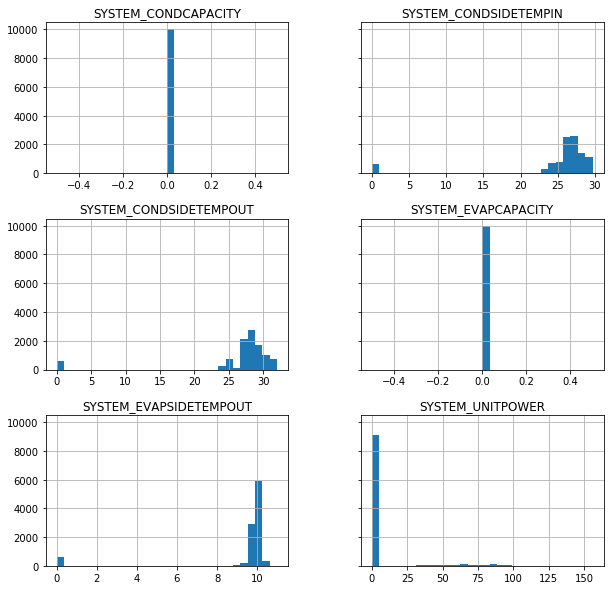

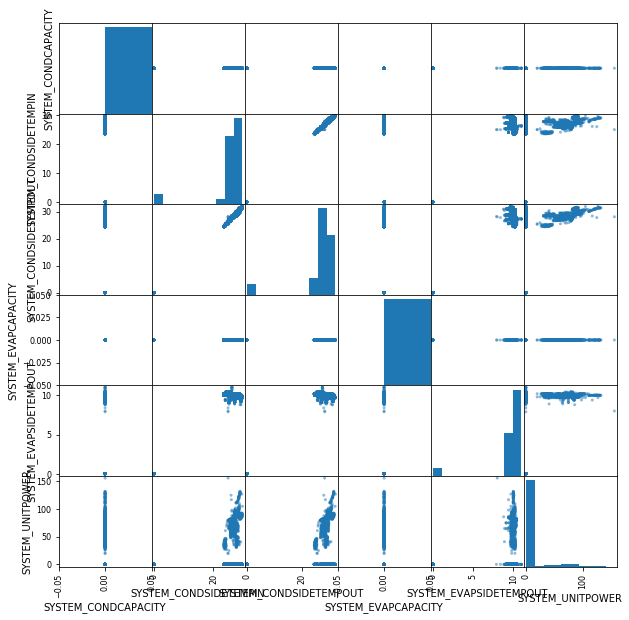

In [4]:
#设备主信息
df_scatter_base = df[[
'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER'
]]

# 显示汇总统计数据
display(df_scatter_base.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_base.hist(bins=30, sharey=True, figsize=(10, 10))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_base,  figsize=(10, 10))
plt.show()

#### (2)第一个设备子机 - 相关性探索后，缩小的特征值范围
字段有：'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',

,1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_1_COMPCURRENT,1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_1_COMPLOAD,1S0Z7F92N86S68KI_1_COMPPOWER,1S0Z7F92N86S68KI_1_COMPRUNTIME,1S0Z7F92N86S68KI_1_COMPSPEED,1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_1_COMPVOLTAGE,1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT,1S0Z7F92N86S68KI_1_ECONPRESS,1S0Z7F92N86S68KI_1_ECONREFRTEMP,1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS,1S0Z7F92N86S68KI_1_INVERTERTEMP,1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_1_MAINLOOPLEVEL
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.0,10000.000000,10000.000000
mean,23.756100,28.483900,32.400760,1.64290,1.613300,4445.754400,8157.567400,18.733340,391.630100,620.642260,272.471870,-101.06701,-61.32155,312.818630,0.0,1.392100,52.006600
std,42.370567,35.759514,4.901487,8.35071,8.228398,213.849676,9992.243743,11.505522,21.777413,57.625246,13.082999,4.85283,2.94495,56.763154,0.0,6.676332,3.228095
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-101.30000,-61.80000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,29.100000,0.00000,0.000000,4447.000000,0.000000,5.100000,381.000000,595.600000,273.100000,-101.30000,-61.50000,248.800000,0.0,0.000000,52.000000
50%,0.000000,0.000000,30.400000,0.00000,0.000000,4458.000000,0.000000,25.600000,397.000000,616.400000,273.100000,-101.30000,-61.50000,354.000000,0.0,0.000000,53.000000
75%,0.000000,67.000000,37.100000,0.00000,0.000000,4470.000000,20153.500000,28.900000,402.000000,654.500000,273.100000,-101.30000,-61.40000,358.600000,0.0,0.000000,53.000000
max,100.000000,109.000000,41.800000,60.00000,65.000000,4470.000000,22910.000000,30.100000,410.000000,736.900000,273.100000,0.00000,0.00000,419.700000,0.0,55.000000,74.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


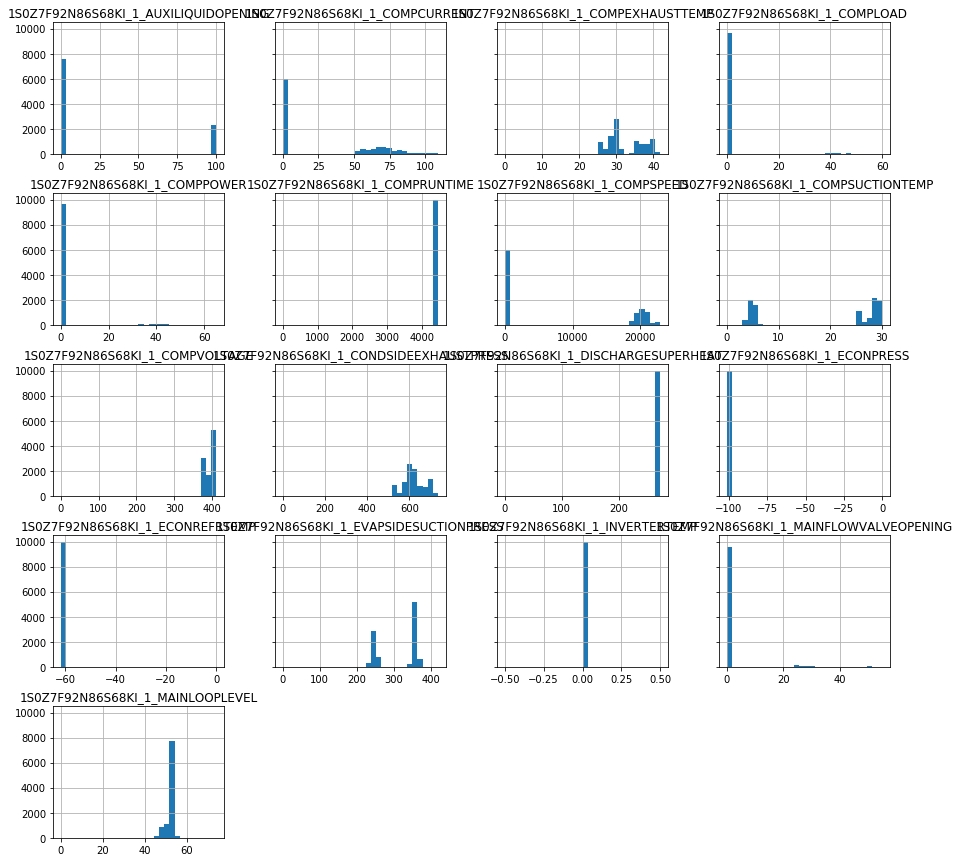

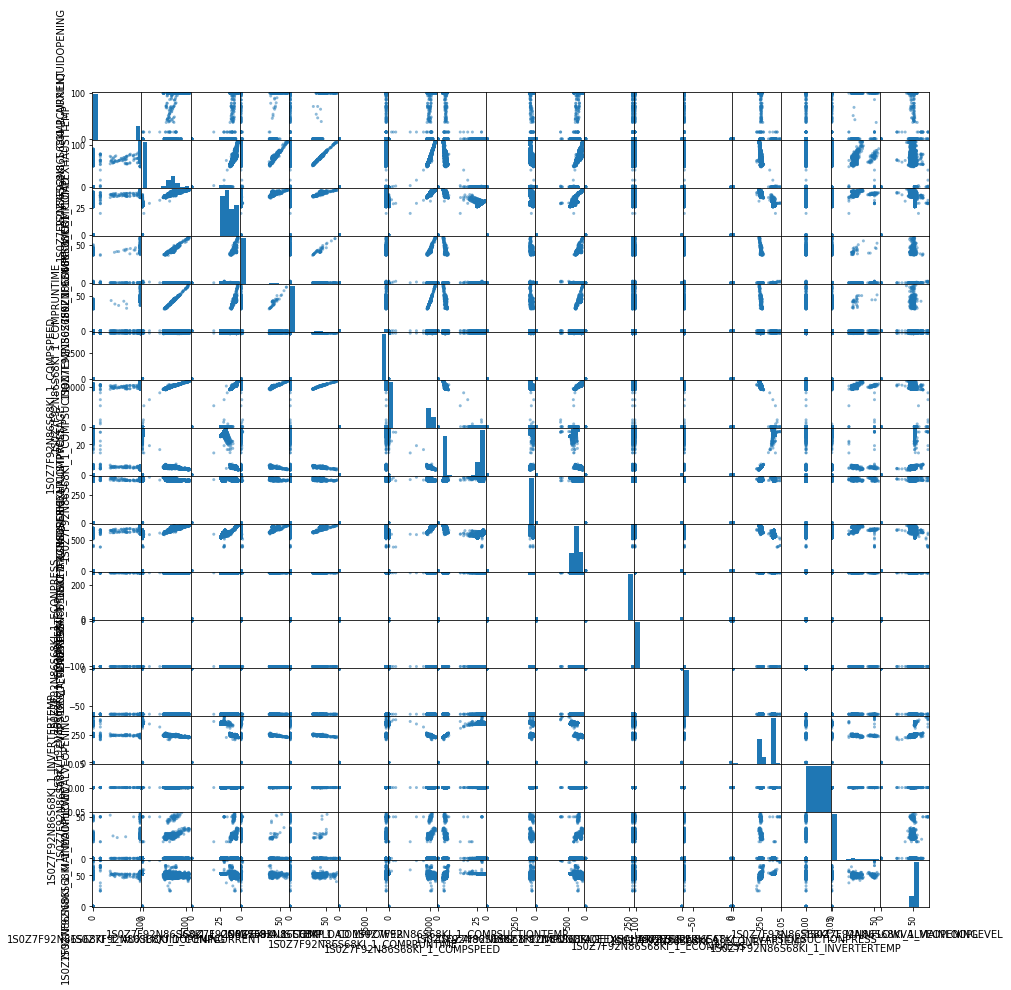

In [5]:
#设备子机 1：
df_scatter_one = df[[
'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',
]]

# 显示汇总统计数据
display(df_scatter_one.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_one.hist(bins=30, sharey=True, figsize=(15, 15))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_one,  figsize=(15, 15))
plt.show()


#### (3)第二个设备子机 - 相关性探索后，缩小的特征值范围
字段有'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL'

#### 其他设备子机同理类推

,1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_2_COMPCURRENT,1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_2_COMPLOAD,1S0Z7F92N86S68KI_2_COMPPOWER,1S0Z7F92N86S68KI_2_COMPRUNTIME,1S0Z7F92N86S68KI_2_COMPSPEED,1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_2_COMPVOLTAGE,1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS,1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT,1S0Z7F92N86S68KI_2_ECONPRESS,1S0Z7F92N86S68KI_2_ECONREFRTEMP,1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS,1S0Z7F92N86S68KI_2_INVERTERTEMP,1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_2_MAINLOOPLEVEL
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,0.007500,0.02870,31.578430,0.006300,0.0045,4412.792500,8.187400,30.910240,394.649300,597.623310,-251.796480,-101.249350,-61.393250,366.225680,0.0,0.039400,67.447100
std,0.335343,1.46741,2.624779,0.551444,0.4500,98.702653,395.065492,2.624181,14.539878,35.118107,6.862608,2.264684,1.374001,11.614237,0.0,1.411257,6.452811
min,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-332.000000,-101.300000,-61.600000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.00000,29.900000,0.000000,0.0000,4415.000000,0.000000,29.100000,382.000000,576.500000,-253.700000,-101.300000,-61.500000,359.800000,0.0,0.000000,59.000000
50%,0.000000,0.00000,31.100000,0.000000,0.0000,4415.000000,0.000000,30.500000,400.000000,599.200000,-252.100000,-101.300000,-61.400000,365.200000,0.0,0.000000,72.000000
75%,0.000000,0.00000,33.600000,0.000000,0.0000,4415.000000,0.000000,33.000000,405.000000,616.500000,-249.400000,-101.300000,-61.400000,373.200000,0.0,0.000000,72.000000
max,15.000000,83.00000,36.800000,55.000000,45.0000,4415.000000,20676.000000,35.800000,413.000000,661.100000,0.000000,0.000000,0.000000,425.200000,0.0,63.000000,75.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


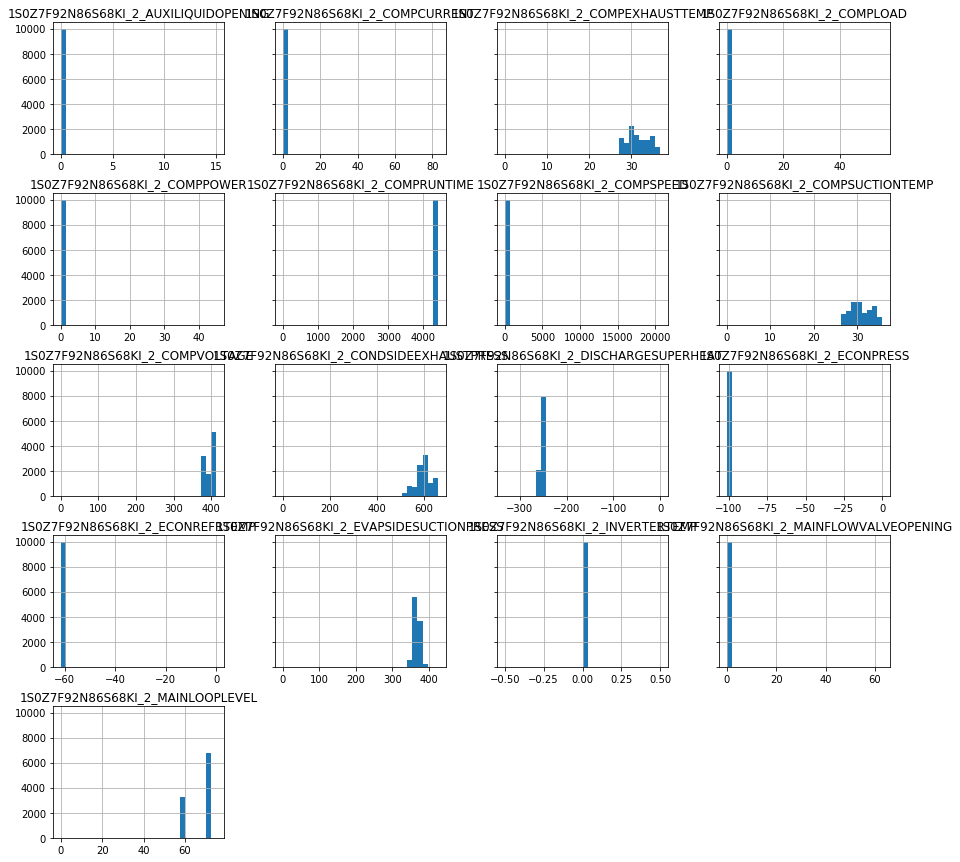

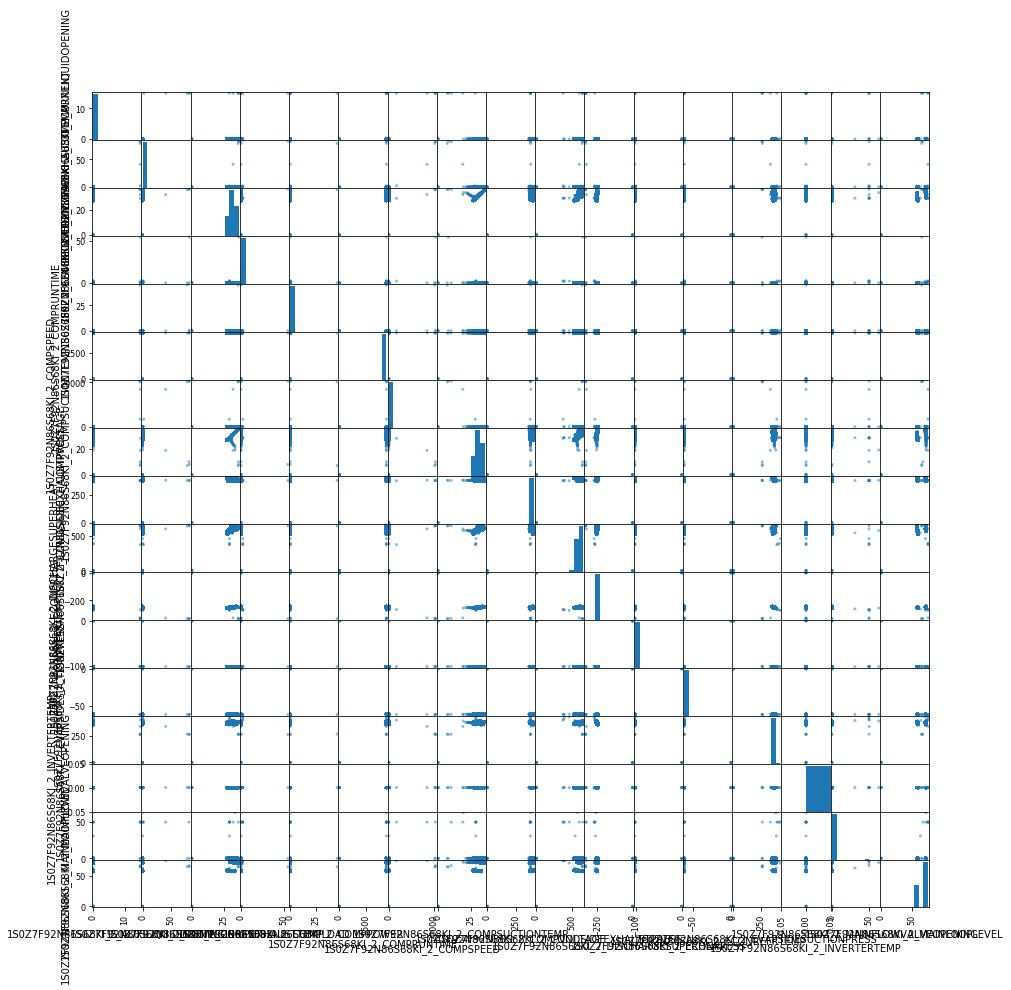

In [6]:
#设备子机 2：
df_scatter_two = df[[
'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL'
]]

# 显示汇总统计数据
display(df_scatter_two.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_two.hist(bins=30, sharey=True, figsize=(15, 15))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_two,  figsize=(15, 15))
plt.show()


### 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。

使用相同的 pandas  crosstab() 和 hist() 函数

1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING


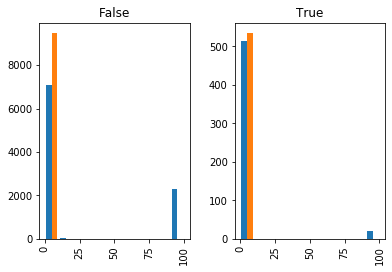

1S0Z7F92N86S68KI_1_COMPCURRENT


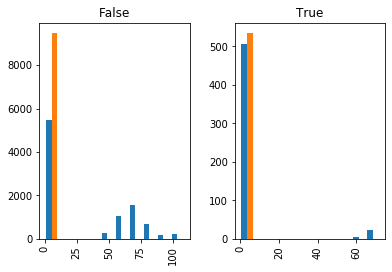

1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP


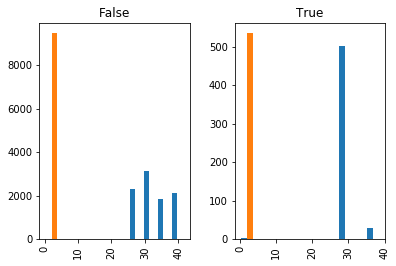

1S0Z7F92N86S68KI_1_COMPLOAD


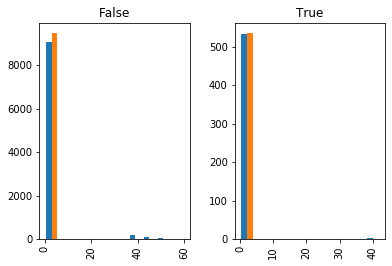

1S0Z7F92N86S68KI_1_COMPPOWER


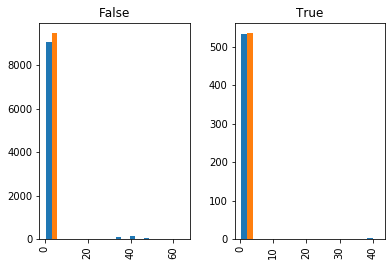

1S0Z7F92N86S68KI_1_COMPRUNTIME


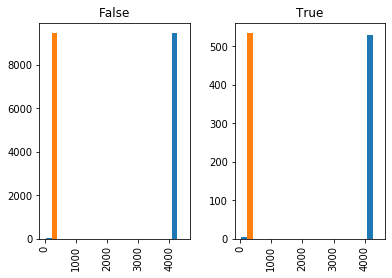

1S0Z7F92N86S68KI_1_COMPSPEED


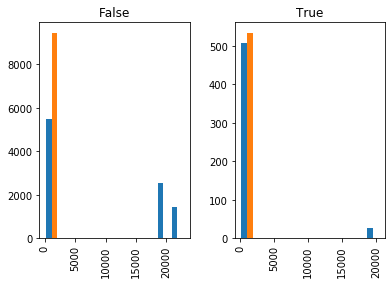

1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP


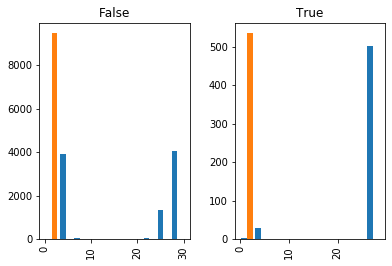

1S0Z7F92N86S68KI_1_COMPVOLTAGE


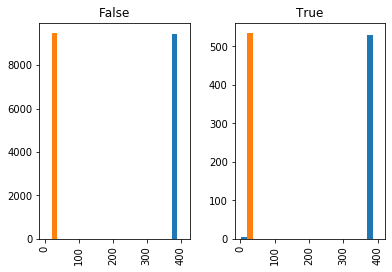

1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS


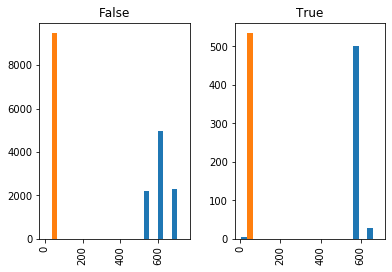

1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT


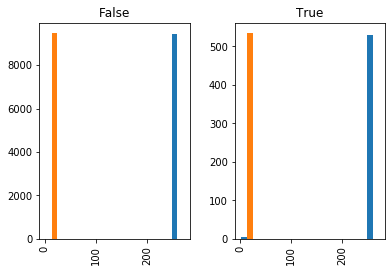

1S0Z7F92N86S68KI_1_ECONPRESS


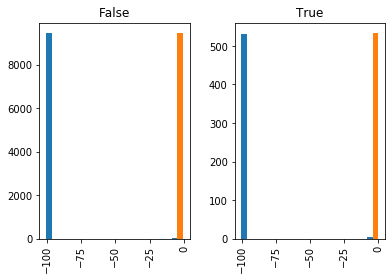

1S0Z7F92N86S68KI_1_ECONREFRTEMP


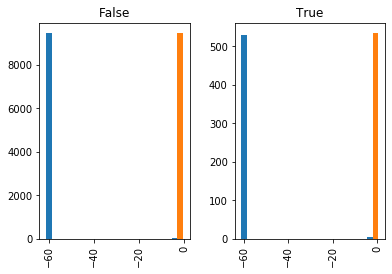

1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS


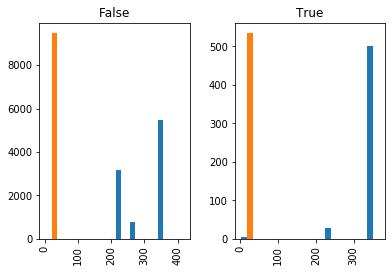

1S0Z7F92N86S68KI_1_INVERTERTEMP


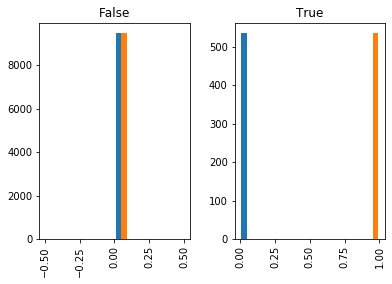

1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING


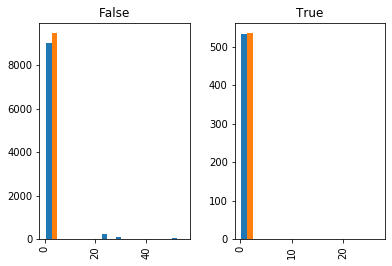

1S0Z7F92N86S68KI_1_MAINLOOPLEVEL


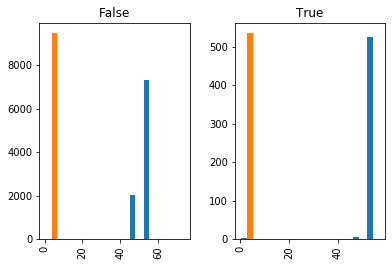

1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING


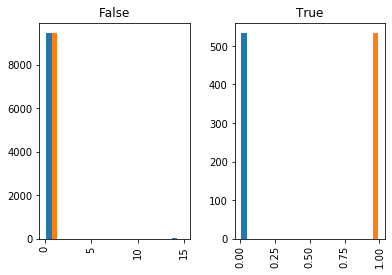

1S0Z7F92N86S68KI_2_COMPCURRENT


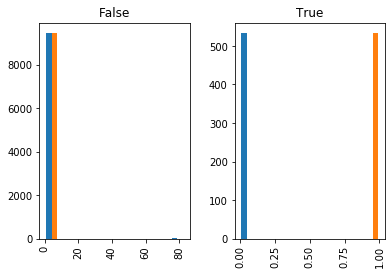

1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP


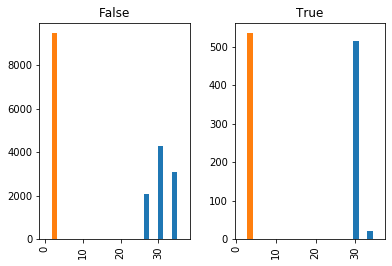

1S0Z7F92N86S68KI_2_COMPLOAD


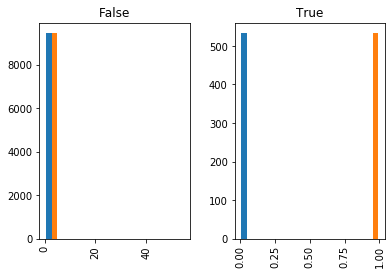

1S0Z7F92N86S68KI_2_COMPPOWER


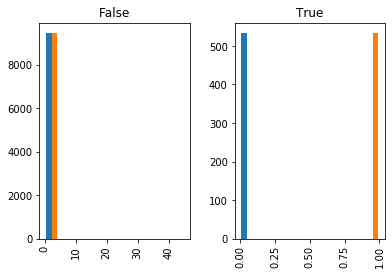

1S0Z7F92N86S68KI_2_COMPRUNTIME


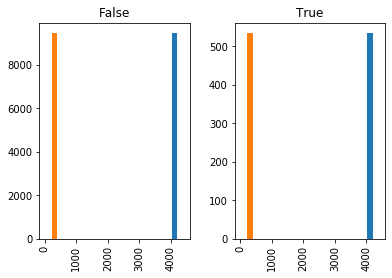

1S0Z7F92N86S68KI_2_COMPSPEED


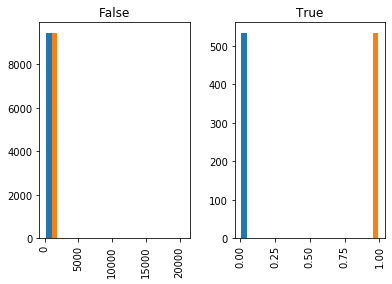

1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP


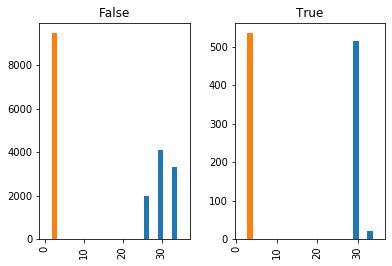

1S0Z7F92N86S68KI_2_COMPVOLTAGE


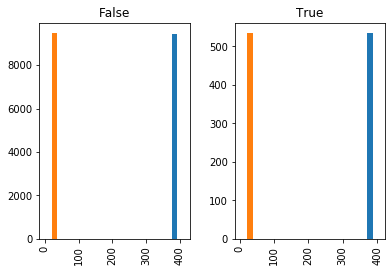

1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS


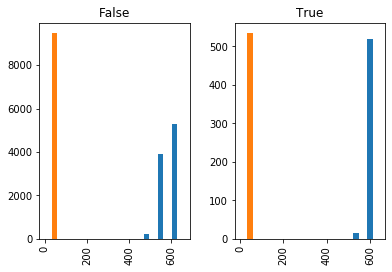

1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT


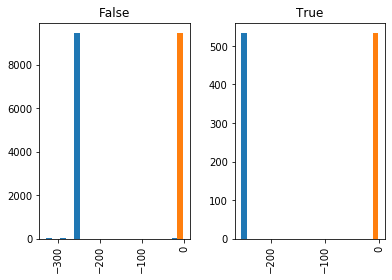

1S0Z7F92N86S68KI_2_ECONPRESS


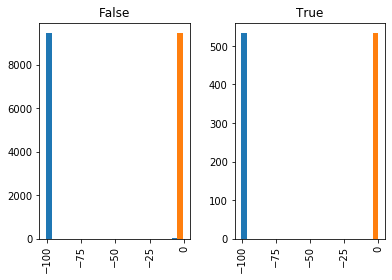

1S0Z7F92N86S68KI_2_ECONREFRTEMP


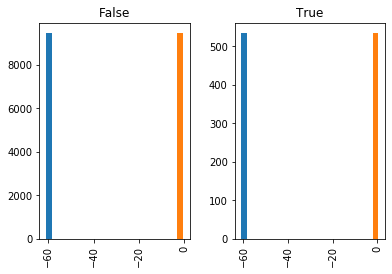

1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS


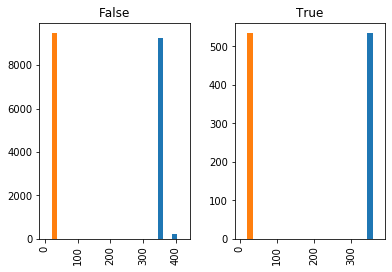

1S0Z7F92N86S68KI_2_INVERTERTEMP


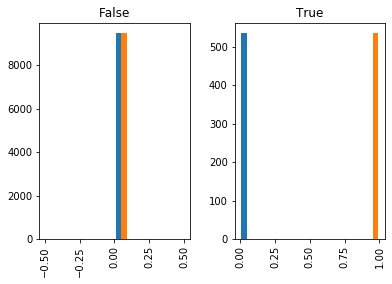

1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING


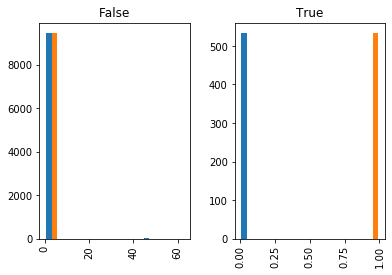

1S0Z7F92N86S68KI_2_MAINLOOPLEVEL


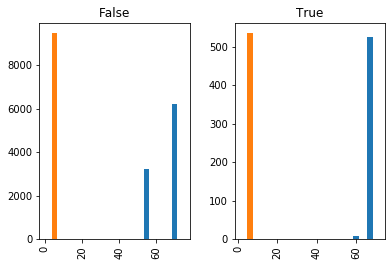

1S0Z7F92N86S68KI_3_AUXILIQUIDOPENING


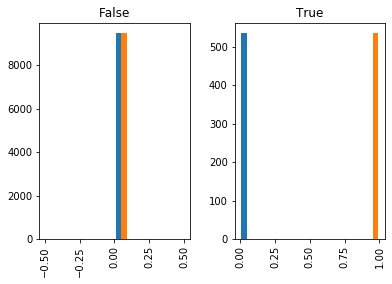

1S0Z7F92N86S68KI_3_COMPCURRENT


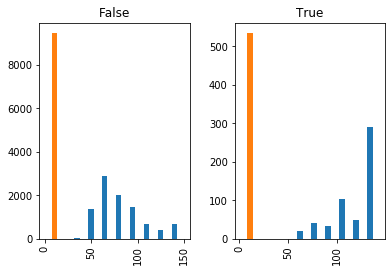

1S0Z7F92N86S68KI_3_COMPEXHAUSTTEMP


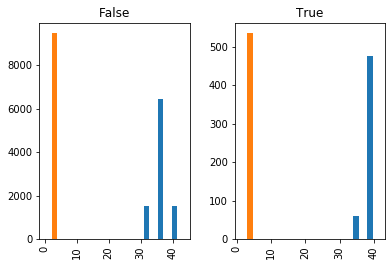

1S0Z7F92N86S68KI_3_COMPLOAD


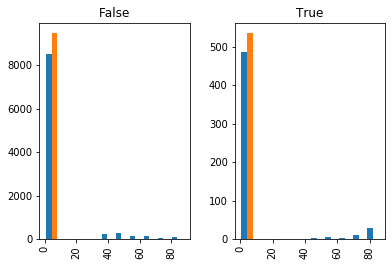

1S0Z7F92N86S68KI_3_COMPPOWER


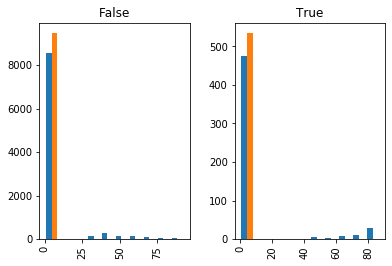

1S0Z7F92N86S68KI_3_COMPRUNTIME


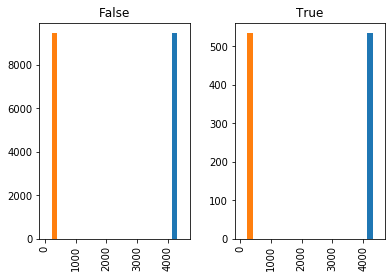

1S0Z7F92N86S68KI_3_COMPSPEED


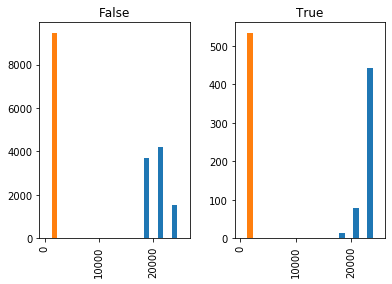

1S0Z7F92N86S68KI_3_COMPSUCTIONTEMP


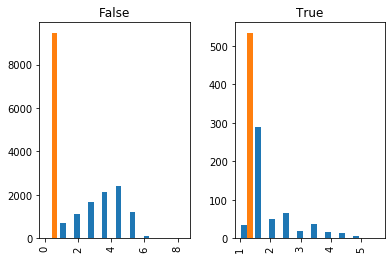

1S0Z7F92N86S68KI_3_COMPVOLTAGE


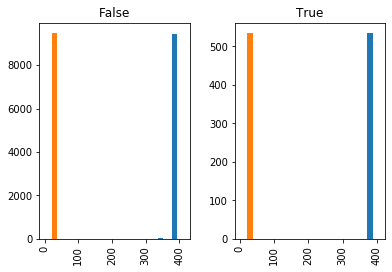

1S0Z7F92N86S68KI_3_CONDSIDEEXHAUSTPRESS


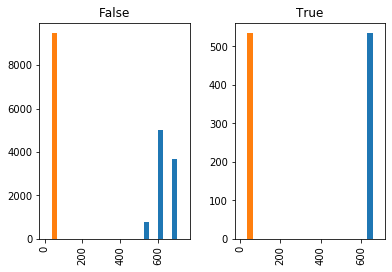

1S0Z7F92N86S68KI_3_DISCHARGESUPERHEAT


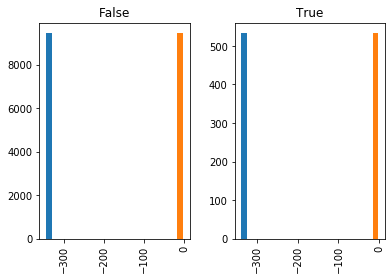

1S0Z7F92N86S68KI_3_ECONPRESS


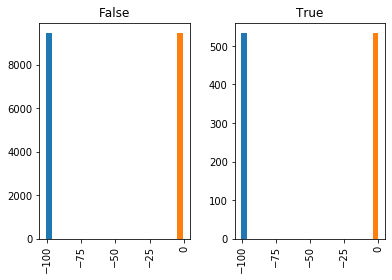

1S0Z7F92N86S68KI_3_ECONREFRTEMP


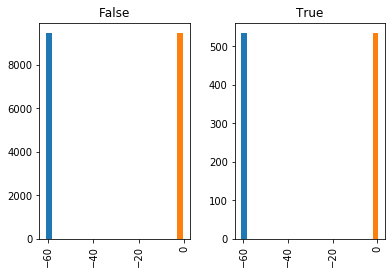

1S0Z7F92N86S68KI_3_EVAPSIDESUCTIONPRESS


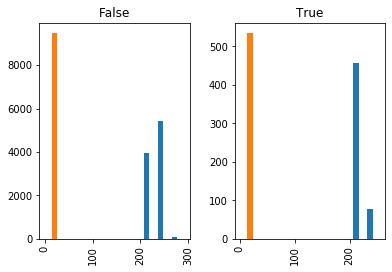

1S0Z7F92N86S68KI_3_INVERTERTEMP


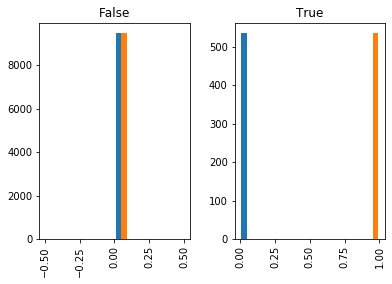

1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING


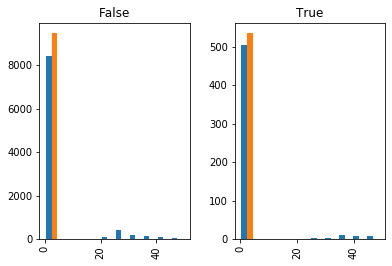

1S0Z7F92N86S68KI_3_MAINLOOPLEVEL


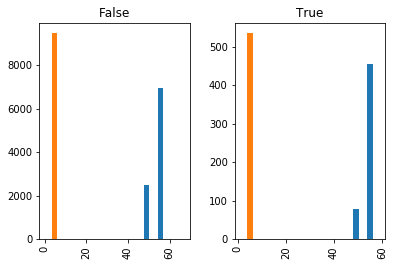

SYSTEM_CONDCAPACITY


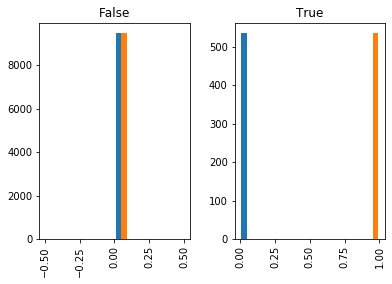

SYSTEM_CONDSIDETEMPIN


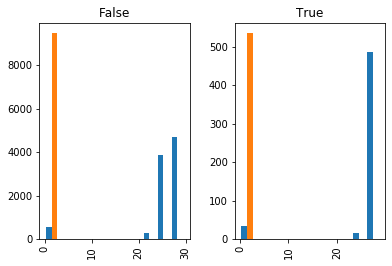

SYSTEM_CONDSIDETEMPOUT


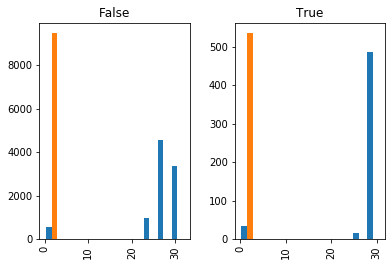

SYSTEM_EVAPCAPACITY


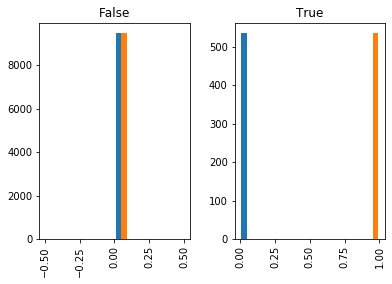

SYSTEM_EVAPSIDETEMPOUT


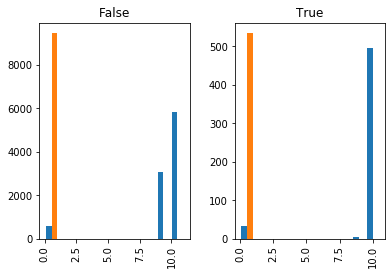

SYSTEM_UNITPOWER


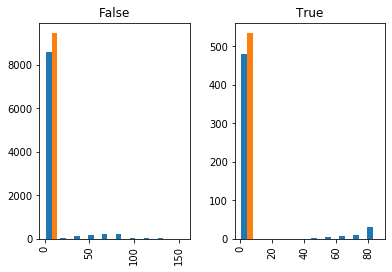

hascode


In [7]:
df_final = df[[
'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',
'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL',
'1S0Z7F92N86S68KI_3_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_3_COMPCURRENT',
'1S0Z7F92N86S68KI_3_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_3_COMPLOAD',
'1S0Z7F92N86S68KI_3_COMPPOWER',
'1S0Z7F92N86S68KI_3_COMPRUNTIME',
'1S0Z7F92N86S68KI_3_COMPSPEED',
'1S0Z7F92N86S68KI_3_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_3_COMPVOLTAGE',
'1S0Z7F92N86S68KI_3_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_3_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_3_ECONPRESS',
'1S0Z7F92N86S68KI_3_ECONREFRTEMP',
'1S0Z7F92N86S68KI_3_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_3_INVERTERTEMP',
'1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_3_MAINLOOPLEVEL',
'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER',
'hascode'
]]

# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。

for column in df_final.select_dtypes(exclude=['object']).columns:
    print(column)
    if column != 'hascode':
        hist = df_final[[column, 'hascode']].hist(by='hascode', bins=10)
        plt.show()

In [8]:
# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
display(df_final.corr())

,1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_1_COMPCURRENT,1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_1_COMPLOAD,1S0Z7F92N86S68KI_1_COMPPOWER,1S0Z7F92N86S68KI_1_COMPRUNTIME,1S0Z7F92N86S68KI_1_COMPSPEED,1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_1_COMPVOLTAGE,1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,...,1S0Z7F92N86S68KI_3_INVERTERTEMP,1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_3_MAINLOOPLEVEL,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER,hascode
1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1.000000e+00,7.702910e-01,7.493370e-01,1.823076e-01,1.967169e-01,2.262688e-02,7.133087e-01,-6.885864e-01,-2.005465e-01,6.748484e-01,...,NaN,-3.277243e-03,-5.072385e-02,NaN,1.290792e-01,1.584062e-01,NaN,-1.603321e-02,6.505040e-02,-1.121783e-01
1S0Z7F92N86S68KI_1_COMPCURRENT,7.702910e-01,1.000000e+00,9.167586e-01,2.402968e-01,2.452151e-01,2.136236e-02,9.852273e-01,-9.669552e-01,-2.523122e-01,7.134726e-01,...,NaN,-1.533229e-02,-3.396723e-02,NaN,9.531285e-02,1.382351e-01,NaN,-6.537487e-03,7.089714e-02,-1.655770e-01
1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,7.493370e-01,9.167586e-01,1.000000e+00,2.199938e-01,2.275548e-01,3.109386e-01,9.081449e-01,-8.372600e-01,2.003467e-02,9.012315e-01,...,NaN,1.113129e-04,-3.940976e-02,NaN,1.220845e-01,1.588082e-01,NaN,-2.975825e-02,6.504251e-02,-1.518139e-01
1S0Z7F92N86S68KI_1_COMPLOAD,1.823076e-01,2.402968e-01,2.199938e-01,1.000000e+00,8.375545e-02,5.140795e-03,2.413868e-01,-2.380145e-01,-5.757957e-02,1.668595e-01,...,NaN,-1.314985e-02,8.686864e-03,NaN,1.913467e-02,2.943426e-02,NaN,-3.604573e-03,4.891973e-02,-4.225583e-02
1S0Z7F92N86S68KI_1_COMPPOWER,1.967169e-01,2.452151e-01,2.275548e-01,8.375545e-02,1.000000e+00,5.231494e-03,2.421050e-01,-2.372976e-01,-6.906778e-02,1.785600e-01,...,NaN,-2.609313e-03,-9.111026e-03,NaN,4.403176e-02,5.427218e-02,NaN,1.775741e-02,1.690371e-02,-4.202950e-02
1S0Z7F92N86S68KI_1_COMPRUNTIME,2.262688e-02,2.136236e-02,3.109386e-01,5.140795e-03,5.231494e-03,1.000000e+00,2.093520e-02,9.969447e-02,8.638792e-01,5.206401e-01,...,NaN,1.776244e-02,-2.032561e-03,NaN,6.973348e-03,7.842419e-03,NaN,-8.572912e-03,1.454992e-03,-1.152486e-02
1S0Z7F92N86S68KI_1_COMPSPEED,7.133087e-01,9.852273e-01,9.081449e-01,2.413868e-01,2.421050e-01,2.093520e-02,1.000000e+00,-9.863709e-01,-2.333019e-01,6.820364e-01,...,NaN,-1.234771e-02,-3.559661e-02,NaN,8.201282e-02,1.238962e-01,NaN,-1.143132e-02,6.202681e-02,-1.688028e-01
1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,-6.885864e-01,-9.669552e-01,-8.372600e-01,-2.380145e-01,-2.372976e-01,9.969447e-02,-9.863709e-01,1.000000e+00,3.264129e-01,-5.717768e-01,...,NaN,1.393631e-02,2.936116e-02,NaN,-6.759745e-02,-1.089263e-01,NaN,3.950709e-03,-5.801172e-02,1.729104e-01
1S0Z7F92N86S68KI_1_COMPVOLTAGE,-2.005465e-01,-2.523122e-01,2.003467e-02,-5.757957e-02,-6.906778e-02,8.638792e-01,-2.333019e-01,3.264129e-01,1.000000e+00,2.073318e-01,...,NaN,1.012248e-02,5.593735e-03,NaN,-4.052921e-02,-5.574175e-02,NaN,-1.107377e-02,-2.895331e-02,-7.545953e-02
1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,6.748484e-01,7.134726e-01,9.012315e-01,1.668595e-01,1.785600e-01,5.206401e-01,6.820364e-01,-5.717768e-01,2.073318e-01,1.000000e+00,...,NaN,2.152307e-02,-4.424830e-02,NaN,1.587116e-01,1.877637e-01,NaN,-2.711720e-02,6.572252e-02,-7.600074e-02


In [9]:
# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
#pd.plotting.scatter_matrix(df_final, figsize=(20, 20))
#plt.show()

### 完成了本章节的内容，包括：
   - [ ] 1）探索相关性；
   - [ ] 2）缩小特征值范围；
   - [ ] 3）确认数据集从282列缩减为58个列
   